In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas')

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,Sloka,Class
0,यस्मात् त्रस्यन्ति भूतानि मृगव्याधान्मृगा इव। ...,Vidur Niti Slokas
1,एतान्यनिगृहीतानि व्यापादयितुमप्यलम्। ...,Vidur Niti Slokas
2,यावत्स्वस्थो ह्यय देहः तावन्मृत्युश्च दूरतः। ...,Chanakya Slokas
3,ईश्वरस्य स्मरणं प्रभाते उत्थाय अवश्यं कर्तं...,sanskrit-slogan
4,लोकयात्रा भयं लज्जा दाक्षिण्यं त्यागशीलता। ...,Chanakya Slokas


In [7]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,Sloka,Class
0,यो यस्मिन् कर्माणि कुशलस्तं तस्मित्रैव योजयेत्...,sanskrit-slogan
1,अध्ययनेन/अध्ययनं वीना ज्ञानं न भवति ॥,sanskrit-slogan
2,पुष्पं पुष्पं विचिन्वीत मूलच्छेदं न कारयेत् । ...,Vidur Niti Slokas
3,मृजया रक्ष्यते रूपम् ॥,sanskrit-slogan
4,मूर्खश्चिरायुर्जातोऽपि तस्माज्जातमृतो वरः। ...,Chanakya Slokas


In [8]:
train_df['Class'].unique()

array(['Vidur Niti Slokas', 'Chanakya Slokas', 'sanskrit-slogan'], dtype=object)

In [9]:
valid_df['Class'].unique()

array(['sanskrit-slogan', 'Vidur Niti Slokas', 'Chanakya Slokas'], dtype=object)

In [10]:
print('In Training data:')
for cls in train_df['Class'].unique():
    print(cls, (train_df['Class'] == cls).sum())

In Training data:
Vidur Niti Slokas 118
Chanakya Slokas 138
sanskrit-slogan 127


In [11]:
print('In Validation data:')
for cls in valid_df['Class'].unique():
    print(cls, (valid_df['Class'] == cls).sum())

In Validation data:
sanskrit-slogan 29
Vidur Niti Slokas 28
Chanakya Slokas 39


In [12]:
train_df['Sloka'][0]

'यस्मात् त्रस्यन्ति भूतानि मृगव्याधान्मृगा इव।                            सागरान्तामपि महीं लब्ध्वा स परिहीयते ॥                               '

In [13]:
train_df.shape, valid_df.shape

((383, 2), (96, 2))

In [14]:
train_df[train_df['Sloka'].isnull()].shape

(0, 2)

In [15]:
valid_df[valid_df['Sloka'].isnull()].shape

(0, 2)

In [16]:
label_cols = list(range(1,train_df.shape[1]))

In [17]:
print(label_cols)

[1]


In [18]:
id_to_col = list(train_df.columns)

In [19]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [20]:
path

PosixPath('/home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas')

In [21]:
class SanskritTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/sanskrit_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [22]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/sanskrit_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(20000)]

In [23]:
itos[:10]

['<unk>', '<s>', '</s>', '▁।', '▁', 'ं', ',', 'ः', '-', 'म्']

In [24]:
# 20,000 is the vocab size that we chose in sentencepiece
sanskrit_vocab = Vocab(itos)

In [25]:
tokenizer = Tokenizer(tok_func=SanskritTokenizer, lang='sa')

In [26]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [34]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=sanskrit_vocab, bs=16)

In [35]:
data_lm.save()

In [36]:
data_lm.show_batch()

idx,text
0,स्थ ो ▁ह्य य ▁देह ः ▁ताव न् मृत्यु श्च ▁दूर तः । ▁तावद ात्म हित ं ▁कुर्यात् ▁प्रण ान्ते ▁किं ▁करिष्यति ॥ ▁ x x bo s ▁ईश्वरस्य ▁स्मरणं ▁प्रभात े ▁उत्थाय ▁अवश्यं ▁ कर्त ं व्य म् ▁॥ ▁ x x bo s ▁लोक यात्रा ▁भयं ▁लज्ज ा ▁दा क्षि ण्य ं ▁त्याग शीलता । ▁पञ्च ▁यत्र ▁न ▁विद्यन्ते ▁न ▁कुर्यात् तत्र ▁सं गति म् ▁॥ ▁ x
1,▁पत त्येक ः ▁एको ▁याति ▁परा ं ▁गति म् ॥ ▁ x x bo s ▁यद् ▁दूरं ▁यद् ▁दुर ाराध ्यं ▁यच्च ▁दूरे ▁व्यवस्थित म् ▁। ▁तत्सर्व ं ▁तपसा ▁साध्य ं ▁तपो ▁हि ▁दुर ति क्रम म् ▁॥ ▁ x x bo s ▁अर्थ ेष णा ▁न ▁ व्यसन ेषु ▁गण्यते ▁॥ ▁ x x bo s ▁विनय ाद् ▁याति ▁पात्र ताम् ▁॥ ▁ x x bo s ▁यज्ञ ो
2,॥ ▁ x x bo s ▁उद्योग सम्पन्न ं ▁स मुपैति ▁लक्ष्मीः ▁॥ ▁ x x bo s ▁यो ▁ध्रुव ाणि ▁परित्यज्य ▁ह्य ध्रुव ं ▁परि से व ते । ▁ध्रुव ाणि ▁तस्य ▁नश्यन्ति ▁च ा ध्रुव ं ▁नष्ट मेव ▁तत् ▁॥ ▁ x x bo s ▁आ क् रु ▁ श् मान ो ▁ना क्रोश ेन ्म न्यु रेव ▁ति ति क्षत ः । ▁आ क्र ो ष्टा र
3,▁राज्ञा ▁तु ▁महाबल ेन ा ▁ वर्ज ्या न्या हु : ▁पण्डित स्त ानि ▁विद्या त् ▁। ▁अल्प प्रज्ञ ै : ▁सह ▁मन्त्र ं ▁न ▁कुर्या त ▁दीर्घ सु त्र ै ▁र भ स ैश्च ा रण ैश्च ▁॥ ▁ x x bo s ▁सुख स्य ▁मूलं ▁धर्मः ▁॥ ▁ x x bo s ▁अष्टौ ▁गुणाः ▁पुरुष ं ▁दीप यन्ति ▁प्रज्ञा ▁च ▁कौ ल्य ं ▁च ▁ दम ः ▁श्रुत
4,▁ x x bo s ▁पुस्तक ेषु ▁च ▁या ▁विद्या ▁पर हस्त ेषु ▁च ▁यद् धन म् ▁। ▁उत्पन्न ेषु ▁च ▁कार्येषु ▁न ▁सा ▁विद्या ▁न ▁तद् धन म् ▁॥ ▁ x x bo s ▁अनर्थ ाः ▁ संघ चारिण ः ▁॥ ▁ x x bo s ▁अ सन् त्याग ात् ▁पाप कृता म पाप ां स् तुल्य ो ▁दण्ड ः ▁ स्पृश ते ▁मिश्र भाव ात् । ▁शुष्क ेण


In [30]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150

In [38]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [39]:
# Loading the pretrained language model on sanskrit wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-sanskrit/language-model/SanskritDataset/models/second_sa_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (383 items)
x: LMTextList
▁ x x bo s ▁यस्मात् ▁त्र स्य न्ति ▁भूतानि ▁मृग व्या ध ान् मृग ा ▁इव । ▁सागर ान् ता मपि ▁मही ं ▁लब्ध्वा ▁स ▁परि ह ीयते ▁॥,▁ x x bo s ▁एतान् यन ि गृहीत ानि ▁व्या पाद यितु मप्य ल म् । ▁अवि धेय ा ▁इव ाद ान् ता ▁ह याः ▁पथ ि ▁कु सार थि म् ▁॥,▁ x x bo s ▁यावत् स्व स्थ ो ▁ह्य य ▁देह ः ▁ताव न् मृत्यु श्च ▁दूर तः । ▁तावद ात्म हित ं ▁कुर्यात् ▁प्रण ान्ते ▁किं ▁करिष्यति ॥,▁ x x bo s ▁ईश्वरस्य ▁स्मरणं ▁प्रभात े ▁उत्थाय ▁अवश्यं ▁ कर्त ं व्य म् ▁॥,▁ x x bo s ▁लोक यात्रा ▁भयं ▁लज्ज ा ▁दा क्षि ण्य ं ▁त्याग शीलता । ▁पञ्च ▁यत्र ▁न ▁विद्यन्ते ▁न ▁कुर्यात् तत्र ▁सं गति म् ▁॥
y: LMLabelList
,,,,
Path: /home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas;

Valid: LabelList (96 items)
x: LMTextList
▁ x x bo s ▁यो ▁यस्मिन् ▁कर्माणि ▁कुशल स्त ं ▁ तस् मित्र ैव ▁योज येत् ▁॥,▁ x x bo s ▁अध्ययनेन ▁/ ▁अध्ययनं ▁वी ना ▁ज्ञानं ▁न ▁भवति ▁॥,▁ x x bo s ▁पुष्प ं ▁पुष्प ं ▁वि चि न् वीत ▁मूल च्छेद ं ▁न ▁कार येत् ▁। ▁माल ाकार ▁इव 

In [40]:
# Fine tuning the prtrained LM on current dataset

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


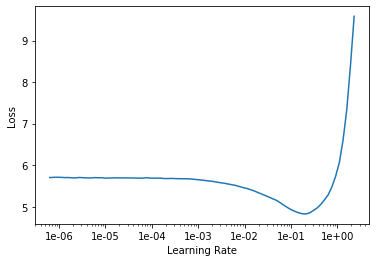

In [42]:
learn.recorder.plot()

In [43]:
learn.freeze()

In [44]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.579320,5.318869,0.275298,00:00


In [45]:
learn.save('fit_head', with_opt=True)

In [46]:
learn.load('fit_head', with_opt=True);

In [47]:
learn.unfreeze()

In [48]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.211967,5.262218,0.277679,00:00
1,5.122273,5.120701,0.283631,00:00
2,4.997240,5.046171,0.290179,00:00
3,4.893634,5.014917,0.291964,00:00
4,4.812481,5.016306,0.292262,00:00


In [49]:
learn.save('fine_tuned', with_opt=True)

In [50]:
learn.load('fine_tuned', with_opt=True);

In [51]:
learn.predict('कश्चित्',n_words=10)

'कश्चित् ▁संस्कृत विद् ं ▁कृति म् ▁क्षेमेन्द्र ः ▁अलिखत् ▁च ▁विन्ध्य'

In [52]:
learn.save_encoder('fine_tuned_enc')

In [27]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=sanskrit_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [28]:
data_clas.show_batch()

text,target
▁ x x bo s ▁षड ि मान् ▁पुरुष ो ▁जह ्य ात् ▁भिन्नं ▁नाव मिव ार्णव े ▁अप्र वक्त ार ं ▁आचार्य ं ▁अन ध्याय िन म् ▁ऋत्विज म् ▁। ▁आरक्षित ार ं ▁राजानं ▁भार्या ं ▁च ाऽ प्रिय वाद िनी ं ▁ग्राम काम ं ▁च ▁गोपाल ं ▁वन काम ं ▁च ▁न ाप ितम् ॥,Vidur Niti Slokas
▁ x x bo s ▁दश ▁धर्म ं ▁न ▁जानन्ति ▁धृतराष्ट्र ▁नि बोध ▁तान् । ▁मत्त ः ▁प्रम त्त ः ▁उन्मत्त ः ▁ श्रान्त ः ▁क्रुद्ध ो ▁बुभुक्षित ः ▁॥ ▁त्व र माण श्च ▁ लु ब्ध श्च ▁भीत ः ▁काम ी ▁च ▁ते ▁दश । ▁तस्माद ेत ेषु ▁सर्वेषु ▁न ▁प्रस ज्ज ेत ▁पण्डितः ▁॥,Vidur Niti Slokas
▁ x x bo s ▁ना क्रोश ी ▁स्यात् राव मान ी ▁पर स्य ▁मित्र द्रोह ी ▁नो त ▁नि च ोप से वी । ▁न ▁च ाभिमान ी ▁न ▁च ▁ हीन वृत्त ो ं ▁ रु क्षा ं ▁वाच ं ▁र ुष ती ं ▁ वर्ज यी त ॥,Vidur Niti Slokas
"▁ x x bo s ▁म र्म ाण्य स्थ ी नि ▁ह्रदय ं ▁तथा सू न् ▁ , रु क्षा ▁वाच ो ▁निर् दह न्ती ह ▁पुं सा म् । ▁तस्माद् ▁वाच ुम ुष ती मु ग्र रुपा ं ▁धर्म ा राम ो ▁नित्य शो ▁ वर्ज यी त ॥",Vidur Niti Slokas
▁ x x bo s ▁न ▁वै ▁ भि त्रा ▁जातु ▁ चरन्ति ▁धर्म ं ▁न ▁वै ▁सुखं ▁प्राप्नुवन् ती ह ▁ भि त्र ाः । ▁न ▁वै ▁सुखं भि त्रा ▁गौरवं प्रा प्नुव न्ति ▁न ▁वै ▁ भि त्रा प्र श म ं रो च यन्ति ▁॥,Vidur Niti Slokas


In [31]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [32]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [35]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (383 items)
x: TextList
▁ x x bo s ▁यस्मात् ▁त्र स्य न्ति ▁भूतानि ▁मृग व्या ध ान् मृग ा ▁इव । ▁सागर ान् ता मपि ▁मही ं ▁लब्ध्वा ▁स ▁परि ह ीयते ▁॥,▁ x x bo s ▁एतान् यन ि गृहीत ानि ▁व्या पाद यितु मप्य ल म् । ▁अवि धेय ा ▁इव ाद ान् ता ▁ह याः ▁पथ ि ▁कु सार थि म् ▁॥,▁ x x bo s ▁यावत् स्व स्थ ो ▁ह्य य ▁देह ः ▁ताव न् मृत्यु श्च ▁दूर तः । ▁तावद ात्म हित ं ▁कुर्यात् ▁प्रण ान्ते ▁किं ▁करिष्यति ॥,▁ x x bo s ▁ईश्वरस्य ▁स्मरणं ▁प्रभात े ▁उत्थाय ▁अवश्यं ▁ कर्त ं व्य म् ▁॥,▁ x x bo s ▁लोक यात्रा ▁भयं ▁लज्ज ा ▁दा क्षि ण्य ं ▁त्याग शीलता । ▁पञ्च ▁यत्र ▁न ▁विद्यन्ते ▁न ▁कुर्यात् तत्र ▁सं गति म् ▁॥
y: CategoryList
Vidur Niti Slokas,Vidur Niti Slokas,Chanakya Slokas,sanskrit-slogan,Chanakya Slokas
Path: /home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas;

Valid: LabelList (96 items)
x: TextList
▁ x x bo s ▁यो ▁यस्मिन् ▁कर्माणि ▁कुशल स्त ं ▁ तस् मित्र ैव ▁योज येत् ▁॥,▁ x x bo s ▁अध्ययनेन ▁/ ▁अध्ययनं ▁वी ना ▁ज्ञानं ▁न ▁भवति ▁॥,▁ x x bo s ▁प

In [36]:
learn.freeze()

In [37]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


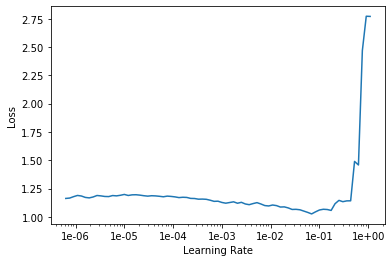

In [38]:
learn.recorder.plot()

In [39]:
learn.loss_func.func

CrossEntropyLoss()

In [40]:
kappa = KappaScore()

In [41]:
learn.metrics = [kappa, accuracy]

In [42]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,1.024088,0.944940,0.432720,0.635417,00:01


In [43]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.938648,0.783173,0.511533,0.687500,00:01


In [44]:
learn.save('second-full')

In [45]:
learn.load('second-full')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (383 items)
x: TextList
▁ x x bo s ▁यस्मात् ▁त्र स्य न्ति ▁भूतानि ▁मृग व्या ध ान् मृग ा ▁इव । ▁सागर ान् ता मपि ▁मही ं ▁लब्ध्वा ▁स ▁परि ह ीयते ▁॥,▁ x x bo s ▁एतान् यन ि गृहीत ानि ▁व्या पाद यितु मप्य ल म् । ▁अवि धेय ा ▁इव ाद ान् ता ▁ह याः ▁पथ ि ▁कु सार थि म् ▁॥,▁ x x bo s ▁यावत् स्व स्थ ो ▁ह्य य ▁देह ः ▁ताव न् मृत्यु श्च ▁दूर तः । ▁तावद ात्म हित ं ▁कुर्यात् ▁प्रण ान्ते ▁किं ▁करिष्यति ॥,▁ x x bo s ▁ईश्वरस्य ▁स्मरणं ▁प्रभात े ▁उत्थाय ▁अवश्यं ▁ कर्त ं व्य म् ▁॥,▁ x x bo s ▁लोक यात्रा ▁भयं ▁लज्ज ा ▁दा क्षि ण्य ं ▁त्याग शीलता । ▁पञ्च ▁यत्र ▁न ▁विद्यन्ते ▁न ▁कुर्यात् तत्र ▁सं गति म् ▁॥
y: CategoryList
Vidur Niti Slokas,Vidur Niti Slokas,Chanakya Slokas,sanskrit-slogan,Chanakya Slokas
Path: /home/gaurav/PycharmProjects/nlp-for-sanskrit/classification-slokas;

Valid: LabelList (96 items)
x: TextList
▁ x x bo s ▁यो ▁यस्मिन् ▁कर्माणि ▁कुशल स्त ं ▁ तस् मित्र ैव ▁योज येत् ▁॥,▁ x x bo s ▁अध्ययनेन ▁/ ▁अध्ययनं ▁वी ना ▁ज्ञानं ▁न ▁भवति ▁॥,▁ x x bo s ▁प

In [46]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.815710,0.725703,0.546482,0.708333,00:01
1,0.807308,0.628630,0.761431,0.843750,00:01
2,0.763013,0.598177,0.745105,0.833333,00:01
3,0.732741,0.599553,0.696859,0.802083,00:01
4,0.697256,0.591389,0.711712,0.812500,00:01


Better model found at epoch 0 with accuracy value: 0.7083333134651184.
Better model found at epoch 1 with accuracy value: 0.84375.


In [47]:
learn.predict(' न दुर्जन: साधुदशामुपैति बहुप्रकारैरपि शिक्ष्यमाण: । आमूलसिक्त: पयसा घृतेन न निम्बवृक्षो मधुरत्वमेति ।।')

(Category Chanakya Slokas, tensor(0), tensor([0.7695, 0.0804, 0.1500]))

In [48]:
learn.predict(" गृहाऽऽसक्तस्य नो विद्या नो दया मासंभोजिन: । द्रव्यलुब्धस्य नो सत्यं स्त्रैणस्य न पवित्रता ।।")

(Category Chanakya Slokas, tensor(0), tensor([0.6119, 0.2062, 0.1819]))

In [49]:
learn.predict("अनुबंधानपक्षेत सानुबन्धेषु कर्मसु। सम्प्रधार्य च कुर्वीत न वेगेन समाचरेत्।")

(Category Vidur Niti Slokas, tensor(1), tensor([0.3522, 0.4332, 0.2147]))

In [50]:
learn.predict("नद्वाविमौ पुरुषौ राजन स्वर्गस्योपरि तिष्ठत: । प्रभुश्च क्षमया युक्तो दरिद्रश्च प्रदानवान्।।")

(Category Vidur Niti Slokas, tensor(1), tensor([0.3665, 0.4100, 0.2234]))